In [19]:
# pip install gymnasium
# pip install pygame

import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import pygame
from utils import *

# 2. First steps

We will start by gaining intuition on the task at hand by running a random agent. Create a
RandomAgent, which selects actions randomly. 

In [4]:
class RandomAgent:
        
    def observe(self, state, action, next_state, reward):
        """Called upon observing a new transistion of the environment"""
        pass
    
    def select_action(self, state):
        """"Pick an action from the given state"""
        return env.action_space.sample()
    
    def update(self):
        """"Called after each environment step. 
        This is where all the training takes place"""
        pass

Run the agent on the environment until the episode is
either truncated or terminated. Store the episode and render (visualize) it.

In [10]:
env = gym.make('MountainCar-v0', render_mode='human')

agent = RandomAgent()

done = False
state, _ = env.reset()
episode_reward = 0

states = []
actions = []
rewards = []

while not done:
    env.render()
    action = agent.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)

    episode_reward += reward
    states.append(state)
    actions.append(action)
    rewards.append(reward)

    state = next_state
    done = terminated or truncated

env.close() 

Now run the agent for 100 episodes. At every episode initialize the environment with a new randomly
sampled seed. Plot the duration of each episode as a scatter plot. What do you find? Explain.

In [17]:
env = gym.make('MountainCar-v0')

agent = RandomAgent()
episode_duration= []
n_episodes = 100
for n in tqdm(range(n_episodes)):

    done = False
    state, _ = env.reset()
    states = []
    episode_reward = 0
    
    while not done:
        states.append(state)
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        state = next_state
        done = terminated or truncated

    episode_duration.append(len(states))

100%|██████████| 100/100 [00:00<00:00, 355.12it/s]


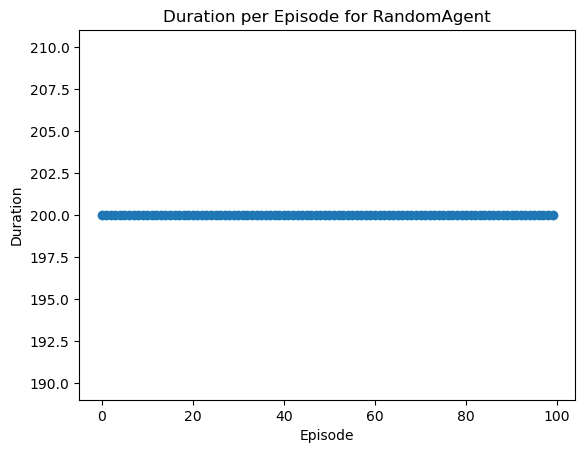

In [18]:
plt.scatter(range(n_episodes), episode_duration)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Duration per Episode for RandomAgent')
plt.show()

We find that by taking random actions, the car is never lucky and cannot finish even a single episode. 

# 3. DQN

## 3.1 Implementation
Create a `DQNAgent` class that implements a DQN agent that uses a feed-forward network to estimate
Q-values and an eps-greedy policy to take actions. Since DQN is an off-policy RL algorithm, make sure
your class has a replay buffer that allows to add observed transitions `(s,a,r,s′)` and sample batches of
transitions for the network updates

In [ ]:
class DQNAgent:
        
    def observe(self, state, action, next_state, reward):
        """Called upon observing a new transistion of the environment"""
        pass
    
    def select_action(self, state):
        """"Pick an action from the given state"""
        pass
    
    def update(self):
        """"Called after each environment step. 
        This is where all the training takes place"""
        pass